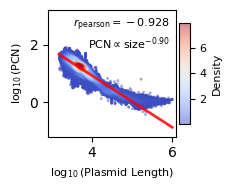

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde, spearmanr, pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 0) Define and verify your file path
file_path = 'Figure_5_data.csv'
assert os.path.exists(file_path), f"File not found: {file_path}"

# 1) Load the full dataset
df_full = pd.read_csv(file_path, low_memory=False)


# 2) Compute log10 transformations for Plasmid Length and PCN
df_full['Log10_Plasmid_Length'] = np.log10(df_full['Plasmid_Length'])
df_full['Log10_PCN'] = np.log10(df_full['PCN'])

# 3) Extract arrays for plotting
x = df_full['Log10_Plasmid_Length'].values
y = df_full['Log10_PCN'].values

# 3a) Filter to only include plasmid lengths (log10) between 3 and 6
mask = (x >= 3) & (x <= 6)
x_f = x[mask]
y_f = y[mask]

# 4) Calculate density using Gaussian KDE
xy = np.vstack([x_f, y_f])  # Stack the x and y values
kde = gaussian_kde(xy)  # Create KDE object
z = kde(xy)  # Calculate the density at each point

# 5) Sort the points by density for proper layering (densest points on top)
idx = z.argsort()  
x_sorted, y_sorted, z_sorted = x_f[idx], y_f[idx], z[idx]

# 6) Calculate Pearson's r and Spearman's rho on the filtered data
r_value, _   = pearsonr(x_sorted, y_sorted)
rho_value, _ = spearmanr(x_sorted, y_sorted)

# 7) Calculate regression slope and intercept
slope, intercept = np.polyfit(x_sorted, y_sorted, 1)

annotation_text = (
    rf"$r_{{\mathrm{{pearson}}}} = {r_value:.3f}$" + "\n" +
    rf"$\mathrm{{PCN}} \propto \mathrm{{size}}^{{{slope:.2f}}}$"
)


# 9) Create the plot with density-based coloring
plt.figure(figsize=(2.5, 2))  # Slightly wider to accommodate colorbar
sc = plt.scatter(
    x_sorted, y_sorted,
    c=z_sorted,  # Color points by their density
    s=4,  # Adjust size as needed
    cmap='coolwarm',  # Color map for density
    edgecolors='none',
    alpha=0.5
)

# Add colorbar
cbar = plt.colorbar(sc, shrink=0.8, aspect=10, pad=0.02)
cbar.set_label('Density', fontsize=8)
cbar.ax.tick_params(labelsize=8)

# 10) Perform linear regression using statsmodels
X = sm.add_constant(x_sorted)  # Add constant for the intercept term
model = sm.OLS(y_sorted, X).fit()

# Generate points for the regression line
x_fit = np.linspace(x_sorted.min(), x_sorted.max(), 100)
X_fit = sm.add_constant(x_fit)
y_fit = model.predict(X_fit)

# Calculate the confidence interval
prediction = model.get_prediction(X_fit)
ci = prediction.conf_int()

# 11) Plot the regression line
plt.plot(x_fit, y_fit, color='red', linewidth=2, alpha=0.8)

# Plot the confidence interval
plt.fill_between(x_fit, ci[:, 0], ci[:, 1], color='red', alpha=0.2)

# 12) Annotate Pearson's and Spearman's correlation
plt.text(
    0.95, 0.95, annotation_text,
    transform=plt.gca().transAxes,
    fontsize=8, verticalalignment='top', horizontalalignment='right'
)

# 13) Axis limits and styling
plt.xlim(2.9, 6.1)
plt.ylim(-1.2, 3.2)
plt.xlabel(r'$\log_{10}$(Plasmid Length)', fontsize=8)
plt.ylabel(r'$\log_{10}$(PCN)', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.tight_layout()

# 14) Save the figure in the same directory
output_dir = os.path.dirname(file_path)
for ext in ['svg', 'pdf', 'tiff']:
    out_path = os.path.join(output_dir, f'S6_B.{ext}')
    plt.savefig(out_path, dpi=1200, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()
